The purpose of this notebook is to apply the proposed algorithm based on spatiotemporally-correlated toy data with 1 covariate (X) and 2 hidden confounders (H1, H2)

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Generating the toy data
This is described in detail in section 2.3.2 of the paper

In [2]:
# almost all of the random variables have exponential covariance matrix
exp_cov = lambda distance: np.exp(-distance / 2)

In [3]:
# function to sample spatially correlated random variables
def sample_field(chol_Sigma, S, is_plot=True):
    n = chol_Sigma.shape[0]
    z = np.dot(chol_Sigma.T, np.random.normal(size=n))
    df = pd.DataFrame(S, columns=["x", "y"])
    df["z"] = z
    
    if is_plot:
        plt.figure()
        sns.heatmap(df.pivot("x", "y", "z"), cmap="Spectral")
        plt.title("Covariance Function")
        plt.show()
        
    return z

# function to sample an exponentially decaying spatial trend
def sample_trend(coordinates, ell, is_plot=True):
    n = coordinates.shape[0]
    dist_sq = np.sum(coordinates**2, axis=1)
    z = np.exp(-dist_sq/ell)
    
    df = pd.DataFrame(coordinates, columns=["x", "y"])
    df["z"] = z
    
    if is_plot:
        plt.figure()
        sns.heatmap(df.pivot("x", "y", "z"), cmap="Spectral")
        plt.title("Covariance Function")
        plt.show()
        
    return z

In [4]:
######################
## parameters
######################
N1 = 25 # number of spatial coordinates along first
N2 = 25 # and along second axis
N = N1*N2 # total number of spatial locations
M = 100 # number of time points

##################################################################
## priors
## note: H1 and H2 represent the H_bar and H_tilde in the paper
##################################################################
muH1 = 0 # mean of H1
sH1 = 1 # sd of H1
muH2 = 1 # mean of H2
sH2 = 1 # sd of H2
rho = 0.5 # product mean E(H1*H2) 

In [5]:
# this is the routine to generate the 25x25 spatial grid with exponentially decaying trend
S = np.array(np.meshgrid(np.arange(1, N1+1), np.arange(1, N2+1))).T.reshape(-1, 2) # spatial grid
coordinates = S.astype(float)

distances = cdist(coordinates, coordinates) # pairwise distances between points
Sigma_exp = np.exp(-distances/2) + 1e-6 # covariance matrix (exponentially decaying)
np.fill_diagonal(Sigma_exp, np.diag(Sigma_exp) + 1e-6) # avoiding numerical underflow
chol_Sigma_exp = cholesky(Sigma_exp, lower=True) # cholesky decomposition for faster/more stable linalg operation

In [19]:
np.exp(-distances/2) + 1e-6 #

array([[1.00000100e+00, 6.06531660e-01, 3.67880441e-01, ...,
        1.08515263e-06, 1.06049107e-06, 1.04263618e-06],
       [6.06531660e-01, 1.00000100e+00, 6.06531660e-01, ...,
        1.11887198e-06, 1.08515263e-06, 1.06049107e-06],
       [3.67880441e-01, 6.06531660e-01, 1.00000100e+00, ...,
        1.16447630e-06, 1.11887198e-06, 1.08515263e-06],
       ...,
       [1.08515263e-06, 1.11887198e-06, 1.16447630e-06, ...,
        1.00000100e+00, 6.06531660e-01, 3.67880441e-01],
       [1.06049107e-06, 1.08515263e-06, 1.11887198e-06, ...,
        6.06531660e-01, 1.00000100e+00, 6.06531660e-01],
       [1.04263618e-06, 1.06049107e-06, 1.08515263e-06, ...,
        3.67880441e-01, 6.06531660e-01, 1.00000100e+00]])

now we are generating the X:

$X_s^t = exp(-\lVert s \rVert _2^2/1000) + (0.2 + 0.1 . sin(2\pi t/100). H1.H2 + 0.5\xi)$

notice two things here:
1. the first exp term is the spatial trend (exponentially decaying)
2. the second term is the temporal trend that follows a periodic sine function
3. the third term is the error with $\xi \sim N(0, exp(-0.5 \lVert u \rVert _2))$

/tmp/ipykernel_1393917/354998704.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(df.pivot("x", "y", "z"), cmap="Spectral")


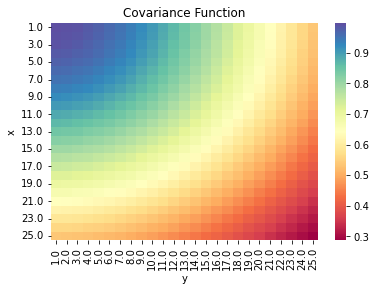

In [24]:
muS_X = sample_trend(coordinates, 1e3, is_plot=True) # spatial trend in X
muT_X = 0.2 + 0.1 * np.sin(2 * np.pi * np.arange(M) / M) # temporal trend in X (M = 100 timesteps)

now we generate both H1 and H2 (hidden confounders), as well as Y as formulated below:

- $H1 \sim N(0, exp(-0.5 \lVert u \rVert _2))$
- $H2 = 1 + 0.5H1 + \frac{\sqrt{3}}{2} \psi$, where $\psi \sim N(0, exp(-0.5 \lVert u \rVert _2))$
- $Y = (1.5 + H1.H2)X + H1^2 + H2.\epsilon$

/tmp/ipykernel_1393917/354998704.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(df.pivot("x", "y", "z"), cmap="Spectral")


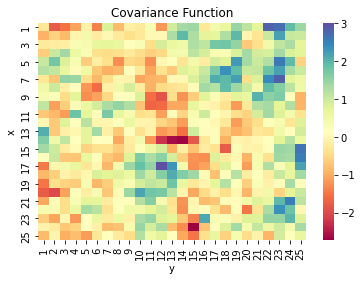

/tmp/ipykernel_1393917/354998704.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(df.pivot("x", "y", "z"), cmap="Spectral")


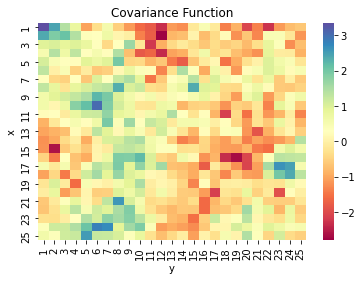

In [26]:
# initialize empty arrays
np.random.seed(1)
X = np.empty((M, N))
Y = np.empty((M, N))
H1 = np.empty((M, N))
H2 = np.empty((M, N))

# sample H1 and H2 using the above formula
h1 = sample_field(chol_Sigma_exp, S, is_plot=True) # formulated above
h2 = muH2 + rho*h1 + np.sqrt(1 - rho**2) * sample_field(chol_Sigma_exp, S, is_plot=True) # formulated above

# sample X and Y for each time step
for t in range(M):
    H1[t,:] = h1
    H2[t,:] = h2
    X[t,:] = muS_X + muT_X[t] * H1[t,:]*H2[t,:] + 0.5 * sample_field(chol_Sigma_exp, S, is_plot=False) # formulated above
    Y[t,:] = (1.5 + H1[t,:]*H2[t,:]) * X[t,:] + H1[t,:]**2 + H2[t,:] * sample_field(chol_Sigma_exp, S, is_plot=False) # formulated above


# Estimating causal effect

Recall the ground-truth formula for $Y$:

$$
\begin{align}
f_{AVE}(X->Y)(x) = (1.5 + E(H1*H2))*x + E(H1^2) + E(H2.\epsilon)\\
= (1.5 + 0.5)*x + Var(H1) + 0 \\
= 2x + 1
\end{align}
$$

In [19]:
# so the ground truth coefficient should be
b1 = rho + 3/2 ## slope: 2
b0 = sH1 ## intercept: 1

In [33]:
# this is to compute the linear regression for each location s (25x25)
def bhat(X, Y, N, M):
    results = list()
    for s in range(0,N):
        Xs = X[:,s]
        Ys = Y[:,s]
        model = LinearRegression().fit(Xs.reshape(-1, 1), Ys.reshape(-1, 1))
        results.append([model.intercept_, model.coef_[0]])

    return np.array(results)

In [34]:
# this is the estimated coefficients when we decorrelate spatial dependency (ie. compute coefficient at each location)
bhat_data = bhat(X, Y, N, M)
b_causal_data = np.mean(bhat_data, axis=0)
print(f"The estimated causal coefficients: a = {b_causal_data[0].item():.2f}, b= {b_causal_data[1].item():.2f}")

The estimated causal coefficients: a = 0.97, b= 2.31


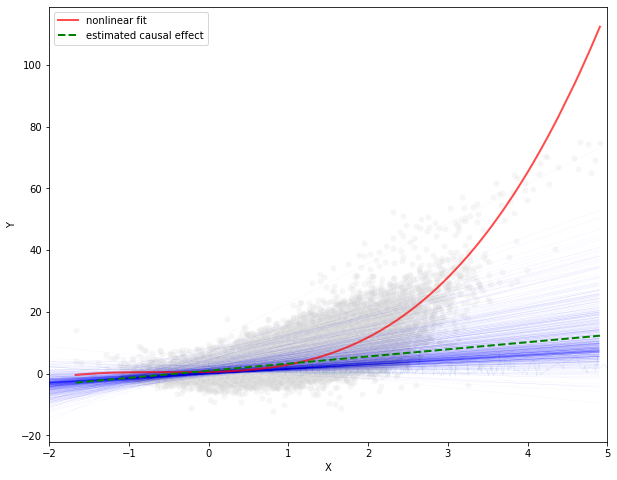

In [35]:
# plotting
## red: nonparametric regression
## thin blue: linear regressions within each location
## green: estimate of the avg causal effect

linedata = pd.DataFrame({'intercept': bhat_data[:, 0, 0], 'slope': bhat_data[:, 1, 0]})
x_increments = np.arange(-2,5,0.1)
p= np.polyfit(X.ravel(), Y.ravel(), 3)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=pd.DataFrame({'X':X.ravel(), 'Y':Y.ravel()}), x='X', y='Y', alpha=.2, color='lightgrey', ax=ax)
sns.color_palette('coolwarm', as_cmap=True)
sns.lineplot(data=linedata, x='slope', y='intercept', alpha=.15, linewidth=.5, ax=ax)
for i in range(bhat_data.shape[0]):
    bhat_d = bhat_data[i]
    sns.lineplot(x=x_increments, y=bhat_d[0] + x_increments * bhat_d[1], color='blue', linewidth=0.2, alpha=0.1, ax=ax)
sns.lineplot(x=X.ravel(), y=p[0] + p[0]*X.ravel() + p[2]*X.ravel()**2 + p[3]*X.ravel()**3, color='red', linewidth=2, alpha=.7, label='nonlinear fit', ax=ax)
sns.lineplot(x=X.ravel(), y=b_causal_data[0] + b_causal_data[1]*X.ravel(), color='green', linewidth=2, linestyle='--', label='estimated causal effect', ax=ax)
ax.set_xlabel('X')
ax.set_xlim(-2,5)
ax.set_ylabel('Y')
plt.show()

# Resampling for hypothesis testing

This is the resampling method used for hypothesis testing (section 3), assumes H to be spatially-invariant so that we can sample for H along the time dimension

In [94]:
def res(Y):
    rng = np.random.default_rng()
    z = rng.choice(M, size=M, replace=False) # temporal permutation
    return Y[z,:] # for each location, identically permute its time dimension

In [95]:
# compute test statistics (ie. the slope)
def test_stat(X, Y):
    bhat_data = bhat(X, Y, N, M)
    return np.mean(bhat_data, axis=0)[1]

In [98]:
def pval(X, Y, B, resampler=res, test_stat=test_stat, is_plt=True):
    t = test_stat(X, Y)
    t_res = np.array([test_stat(X, resampler(Y)) for b in range(B)]) # create an array of B resampled test statistics
    pv = min(1, 2 * min((1 + np.sum(t_res <= t)) / (1 + B), (1 + np.sum(t_res >= t)) / (1 + B)))
    if is_plt:
        sns.histplot(t_res, bins=20)
        plt.axvline(x=t.item(), color='red')
        plt.show()
    return pv

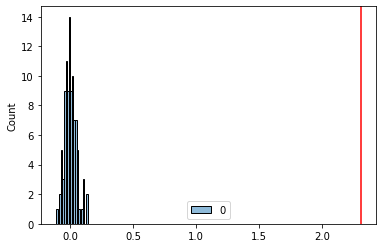

lowest p-value: 0.02


In [100]:
B = 99 # number of permutations
p_val = pval(X, Y, B, res, test_stat) 
print(f"lowest p-value: {p_val}") # pv = 0.02 (at threshold of 0.05, estimated causal coefficient is significant)